In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score, roc_auc_score

# 1. Сформируем задачу регрессии

In [11]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

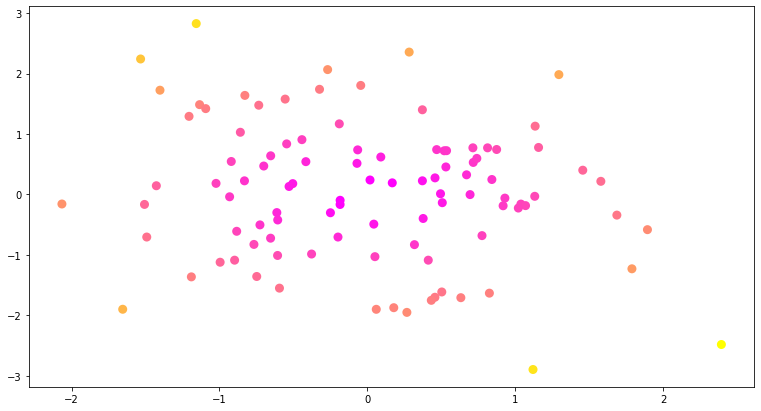

In [12]:
fig, ax = plt.subplots(figsize=(13,7))
data_x = np.random.randn(100,2)
data_y = (data_x[:,0]**2 + data_x[:,1]**2)**0.5
ax.scatter(data_x[:,0],data_x[:,1], c=data_y, cmap='spring', lw=3)


***2. Создадим дерево***

In [14]:
from sklearn.tree import DecisionTreeRegressor

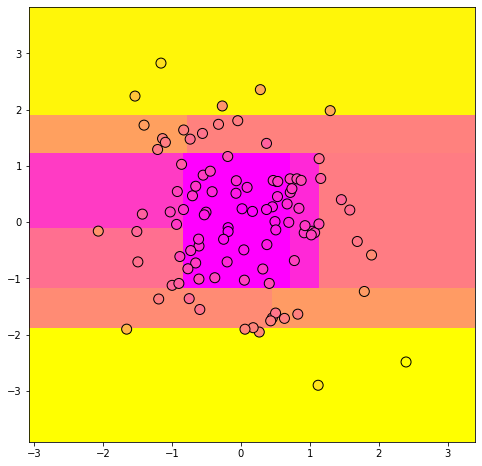

In [15]:
clf = DecisionTreeRegressor(max_depth=5,min_samples_leaf=5, random_state=42)
clf.fit(data_x, data_y)
xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')



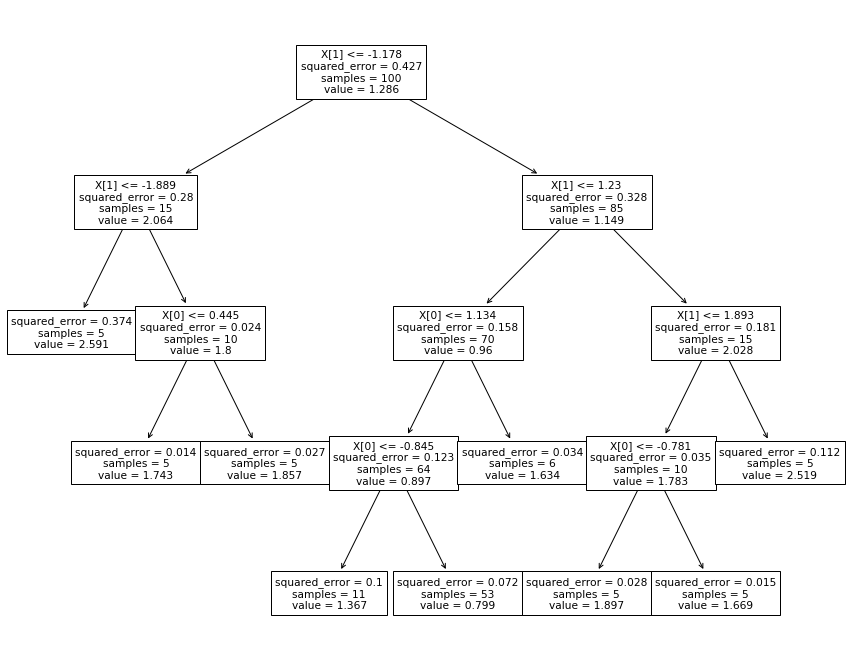

In [21]:
from sklearn import tree
reg = DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, random_state=42)
fig, ax = plt.subplots(figsize=(15,12))
tree.plot_tree(reg.fit(data_x,data_y))
plt.show()

- Увеличение максимальной глубины и/или уменьшение минимального количества объектов выборки в листе приводит к увеличению качества на обучающей выборке и переобучению

***3. Подбор параметров на данных из либы***

In [22]:
from sklearn.datasets import load_boston
import pandas as pd

data = load_boston()
X = data.data
y = data.target
z = data.feature_names
df = pd.DataFrame(np.c_[X,y], columns=list(z)+['target'])
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [23]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn import tree

In [24]:
gs = GridSearchCV(DecisionTreeRegressor(random_state=42),
             param_grid={
                 'max_depth':[1, 2, 4, 6, 8, 10, 20, 50],
                 'min_samples_leaf':[1, 4, 8, 32]
             },
             cv = KFold(5, shuffle=True, random_state=241),
             scoring='r2').fit(X,y)
gs.best_score_,gs.best_estimator_

(0.7601131628418506,
 DecisionTreeRegressor(max_depth=6, min_samples_leaf=4, random_state=42))

***4. Сравним c линейной регрессией***

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [60]:
gs_best = DecisionTreeRegressor(max_depth=6, min_samples_leaf=4, random_state=42)
gs = DecisionTreeRegressor(random_state=42)
lin_reg = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

y_pred_gs_best = gs_best.fit(X_train, y_train).predict(X_test)
y_pred_gs = gs.fit(X_train, y_train).predict(X_test)
y_pred_lin = lin_reg.fit(X_train, y_train).predict(X_test)

print(f'Optimal trees r2 = {r2_score(y_test, y_pred_gs_best)}\n\
Ordinar trees r2 = {r2_score(y_test, y_pred_gs)}\n\
Linear Regression r2 = {r2_score(y_test, y_pred_lin)}')


Optimal trees r2 = 0.8303565245160103
Ordinar trees r2 = 0.8444833592340152
Linear Regression r2 = 0.7112260057484912


посмотрим по кроссвалидации и на графики

Optimal trees r2 = 0.7601131628418506
Ordinar trees r2 = 0.7063196219106335
Linear Regression r2 = 0.714058415490569


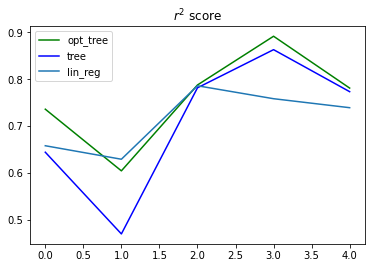

In [11]:
cv1 = cross_val_score(DecisionTreeRegressor(max_depth=6, min_samples_leaf=4, random_state=42),
                      X, y, 
                      cv = KFold(n_splits=5, shuffle=True, random_state=241),
                     scoring='r2')
cv2 = cross_val_score(DecisionTreeRegressor(random_state=42),
                      X, y, 
                      cv = KFold(n_splits=5, shuffle=True, random_state=241),
                     scoring='r2')
cv3 = cross_val_score(LinearRegression(),
                      X, y, 
                      cv = KFold(n_splits=5, shuffle=True, random_state=241),
                     scoring='r2')

plt.plot(cv1, label='opt_tree', c='g')
plt.plot(cv2, label='tree', c='b')
plt.plot(cv3, label='lin_reg')
plt.title('$r^2$ score')
plt.legend()
print(f'Optimal trees r2 = {cv1.mean()}\n\
Ordinar trees r2 = {cv2.mean()}\n\
Linear Regression r2 = {cv3.mean()}')

***5. Проведем standart scaler)***

Optimal trees r2 = 0.7601131628418506
Ordinar trees r2 = 0.7063196219106335
Linear Regression r2 = 0.7140584154905701


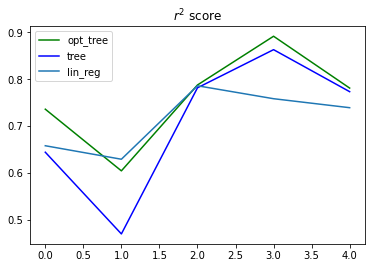

In [12]:
from sklearn.preprocessing import StandardScaler
pca = StandardScaler()
df_scaled = pca.fit_transform(df.iloc[:,:-1])
X = df_scaled

cv1 = cross_val_score(DecisionTreeRegressor(max_depth=6, min_samples_leaf=4, random_state=42),
                      X, y, 
                      cv = KFold(n_splits=5, shuffle=True, random_state=241),
                      scoring='r2')
cv2 = cross_val_score(DecisionTreeRegressor(random_state=42),
                      X, y, 
                      cv = KFold(n_splits=5, shuffle=True, random_state=241),
                     scoring='r2')
cv3 = cross_val_score(LinearRegression(),
                      X, y, 
                      cv = KFold(n_splits=5, shuffle=True, random_state=241),
                     scoring='r2')

plt.plot(cv1, label='opt_tree', c='g')
plt.plot(cv2, label='tree', c='b')
plt.plot(cv3, label='lin_reg')
plt.title('$r^2$ score')
plt.legend()
print(f'Optimal trees r2 = {cv1.mean()}\n\
Ordinar trees r2 = {cv2.mean()}\n\
Linear Regression r2 = {cv3.mean()}')

Вывод, дерево с подобранными параметрами справилось лучше

# Сформируем задачу классификации

In [61]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [62]:
X = load_iris(as_frame=True)['data']
y = load_iris(as_frame=True)['target']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf1 = DecisionTreeClassifier(max_depth=2, random_state=42)
clf1.fit(X_train, y_train)
y_pred1 = reg1.predict(X_test)

accuracy_score(y_test, y_pred1), roc_auc_score(y_test, clf1. predict_proba(X_test), multi_class='ovo')

(0.9777777777777777, 0.9871794871794872)

In [72]:
reg1.predict_proba(X_test)[:3] # выдает вероятности принадлежности к классу

array([[0.        , 0.96969697, 0.03030303],
       [1.        , 0.        , 0.        ],
       [0.        , 0.12195122, 0.87804878]])

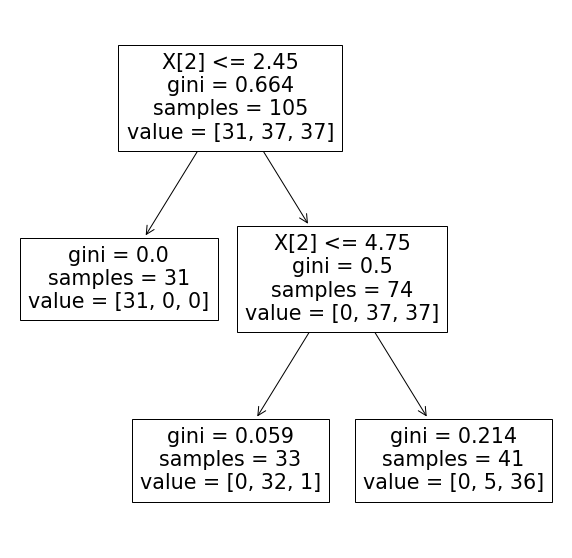

In [78]:
fig, ax = plt.subplots(figsize=(10,10))
tree.plot_tree(clf1)
plt.show()
# Value выдает количество элементов каждого класса

***1. Найдем лучшие параметры***

In [97]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), 
            param_grid={
                 'max_depth':[1, 2, 4, 6, 8, 10, 20, 50],
                 'min_samples_leaf':[1, 4, 8, 32]
             },
             cv = KFold(5, shuffle=True, random_state=241),
             scoring='roc_auc_ovr').fit(X_train,y_train)
gs_best
gs.best_score_

0.9709023569023569

2. Сравним с Логистической регрессией

Optimal trees roc_auc = 0.975252683314087
Ordinar trees roc_auc = 0.9433019656355569
Linear Regression roc_auc = 0.996384475727613


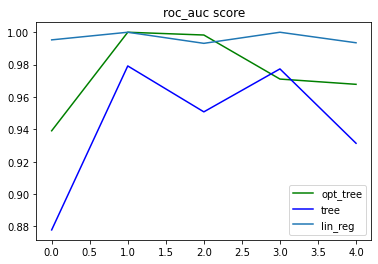

In [104]:
cv1 = cross_val_score(DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, random_state=42),
                      X, y, 
                      cv = KFold(n_splits=5, shuffle=True, random_state=241),
                     scoring='roc_auc_ovr')
cv2 = cross_val_score(DecisionTreeClassifier(random_state=42),
                      X, y, 
                      cv = KFold(n_splits=5, shuffle=True, random_state=241),
                     scoring='roc_auc_ovr')
cv3 = cross_val_score(LogisticRegression(random_state=42),
                      X, y, 
                      cv = KFold(n_splits=5, shuffle=True, random_state=241),
                     scoring='roc_auc_ovr')

plt.plot(cv1, label='opt_tree', c='g')
plt.plot(cv2, label='tree', c='b')
plt.plot(cv3, label='lin_reg')
plt.title('roc_auc score')
plt.legend()
print(f'Optimal trees roc_auc = {cv1.mean()}\n\
Ordinar trees roc_auc = {cv2.mean()}\n\
Linear Regression roc_auc = {cv3.mean()}')